In [6]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import LinearLocator
from scipy import interpolate
import scipy.integrate as integrate
from datetime import datetime


### DImensional

In [7]:
# Define parameters to be used for the whole solver

# volume ratios
phi_s = 0.85# volume ratio of solid mass
phi_fs = 0.1 # % of fines in ground coffee
phi_f = phi_fs*phi_s # volume ratio of fines in bed
phi_l = 1-phi_s  # volume ratio of extragranular porosity
phi_bf = 1-phi_fs # % of boulders in ground coffee
phi_b = phi_bf*phi_s  #  volume ratio of boulders to whole bed
phi_lb = 0.4 # boulder porosity
phi_T = phi_l + phi_b*phi_lb # total porosity in bed

# grain params
af = 3.65*1e-6 # m mean fine radius
ab = 228.69*1e-6 # m mean boulder radius
b_f = 3*phi_f/af # 1/m surface/volume ratio of fines
b_b = 3*phi_b/ab # 1/m surface/volume ratio of boulders

# flow params
Ptot = 9.2*10**6 # pascals, applied pressure
L =  0.0084 # m bed height
mu = 0.0003149 # viscosity at 90C
t_drip = 5 # first drip time
kappa = phi_T*L**2*mu/(2*Ptot*t_drip) # m^2 fit permeability

In [8]:
def dim_flow(t_vals, t_drip): 
    # define flow profile, pre-first drip estimated 
    #   as darcy flux, after first drip as linear fit to data
    # in:    
    #     t_vals: time interval
    #     t_drip: first drip time
    # out:
    #     combined_flow, np.array of flow profile defined at t_vals
    
    # Darcy solution
    flow = kappa/mu * Ptot / (np.sqrt( 2*kappa*Ptot / ( mu*phi_T)*t_vals ) ) 
    #linear fit from data
    m,c = 2.3621915934596956e-05, -7.442495159999556e-06    
    data_flow = m*t_vals + c
    
    # smoothing coefficient to combine the two flows for numerical stability
    k = 6
    on_at_5 = 0.5*( 1 + np.tanh( k*( t_vals - t_drip ) ) )
    off_at_5 = ( 1 - 0.5*( 1 + np.tanh( k*(t_vals - t_drip) ) ) )
    
    combined_flow = off_at_5*flow + on_at_5*data_flow
    return combined_flow

/tmp/ipykernel_18075/3884895360.py:11: RuntimeWarning: divide by zero encountered in divide
  flow = kappa/mu * Ptot / (np.sqrt( 2*kappa*Ptot / ( mu*phi_T)*t_vals ) )


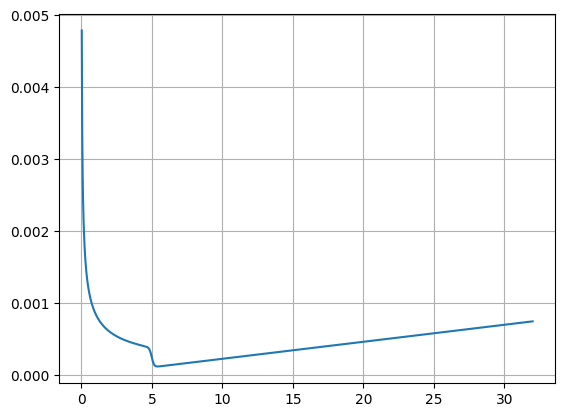

In [9]:
# flow profile
tend = 32 # dimensional s
Nt = 1000
t_int = np.linspace(0, tend, Nt)
q = dim_flow(t_int, t_drip)
plt.plot(t_int,q)
plt.grid()
plt.show()

In [10]:
def sw_dim(t_vals):
    # define position of the wetting front
    sw = np.sqrt( 2*kappa*t_vals*Ptot / ( mu * phi_T ) )
    return sw

### Non-dimensionalise

In [11]:
# dimensionless params
cl0 = 0.0 # initial concentration in liquid
qapp = 2*kappa*Ptot/(L*mu) # typical flow rate pre-first drip
b0 = (b_f + b_b)/2
Qf = phi_T/(af*b0)
Qb = phi_T/(ab*b0)
bf = b_f/b0
bb = b_b/b0

## The flow problem with fixed pressure BC


# Boulders
Solve for the position of saturation front:


The leading order problem to be solved for the transport within the boulders is
$$\frac{\partial c_{b,0}^{(i)}}{\partial t} = \frac{1}{r_b^{2}} \frac{\partial}{\partial r_b} \left( r_b^{2} D_{sb} \frac{\partial c_{b,0}^{(i)}}{\partial r_b} \right) \quad \mbox{with} \\
 -D_{sb} \frac{\partial c_{b,0}^{(i)}}{\partial r_b} \Big{|}_{r_b=0} = 0, \quad c_{b,0}^{(i)}|_{r_b=1}=c_{l,0}^{(i)}.  $$
 


In [12]:
def boulder_rhs(c,cl_out,Dsb):
# a finite difference scheme for spatial discretisation
#     input: c = value of function defned at grid points. size Mx1
#            cl_out = cl value at the boundary of boulder
# 
#     output: dudt = vector of discretised derivatives on Mx1 grid; dudt[-1] not used = 0.
    M = len(c) 
    dudt = np.zeros(M, dtype='float16')
    dr = 1/(M-1)
    dr2 = dr**2
    
    c[-1] = cl_out # BC at r=1
    
    dudt[0] = 6 / dr2 * (c[1] - c[0])  # BC at r=0
    for i in range(1, M - 1):
        dudt[i] = (
            1 / (i * dr2) * ((i + 1) * c[i + 1] - 2 * i * c[i] + (i - 1) * c[i - 1])
        )
    return Dsb * dudt 


In [13]:
# derivative of saturation front
def dsdt(q,cl_s,cf0):
    dsdt = q / (phi_l / phi_T + bf / (3 * Qf) * (cf0 - cl_s) / (1 - cl_s)) 
    return dsdt

## The full problem:

 $$
G =  \frac{-D_{sb}}{Q_b} \frac{\partial c_{b,0}^{(i)}}{\partial r_b} \Big{|}_{r_b=1},$$
 and 
 $$\frac{ds_d}{dt} = q \left( \frac{\phi_l}{\phi_T} + \frac{b_f}{3Q_f} \frac{c_{f,\text{init}}-c^{(i)}_{l,0}|_{z=s_d(t)}}{1-c^{(i)}_{l,0}|_{z=s_d(t)}} \right)^{-1} \quad \mbox{with} \quad s_d|_{t=0}=0.$$
 we write:
 $\eta = \frac{z}{s_d}$ so 
 $ \frac{\partial}{\partial z} = \frac{1}{s_d} \frac{\partial}{\partial \eta} $ and $ \frac{\partial}{\partial t} = \frac{\partial}{\partial t} - \eta \frac{\dot{s_d}}{s_d}\frac{\partial}{\partial \eta}$
 
 then (1) BECOMES:
 $$
 \frac{\partial c}{\partial t} = \left( -  \frac{q(t)}{A s_d} + \eta \frac{\dot{s_d}}{s_d} \right) \frac{\partial c}{\partial \eta} + \frac{G}{A}
 $$
 with $c|_{\eta=0} = 0$ and $c|_{t=0} = 0$
 Backward Euler + upwind:
 $$
 c_i^{j+1} \left( \frac{1}{\Delta t} - \frac{q^{j+1}}{A s_d \Delta \eta} - \frac{\eta_i \dot{s_d}^{j+1}}{\Delta \eta s_d^{j+1}} \right) = \frac{c_i^j}{\Delta t} - \left( - \frac{q^{j+1}}{A s_d \Delta \eta} + \frac{\eta_i \dot{s_d}^{j+1}}{\Delta \eta s_d^{j+1}} \right) c_{i-1}^{j+1} + \frac{G^{j}}{A}
 $$


In [14]:
def make_coffee(Dsb,csat,cf0, cb0, fig=0):
    # numerical solver for the problem above

    runtime = datetime.now()
    N = 400  # points in z
    z = np.linspace(0, 1, N)
    dz = 1 / (N - 1)

    Nt = 3000 # points in t
    tend = 32 # dimensional s
    tend_nd = tend/t_drip
    t_int = np.linspace(0, tend_nd, Nt)
    dt = tend_nd / (Nt - 1)

    cl = np.zeros((Nt, N))
    sd = np.zeros(Nt)
    G_z = np.zeros(N)


    q = dim_flow(t_int*t_drip, t_drip)/qapp
    A = phi_l / phi_T + bf / (3 * Qf)

    M = 30
    r = np.linspace(0, 1, M)
    dr = 1 / (M - 1)
    cb_all = np.zeros((N, M)) + cb0 + phi_lb
    cb_tens = []; cb_tens.append(cb_all)

    wet = 0
    for i in range(Nt - 1):
        # (i) find region (I) interface (step sd):
        cl_last = cl[i, :]
        if sd[i] < 1:
            sd[i + 1] = sd[i] + dt * dsdt(q[i+1], cl_last[-1],cf0)
            #sd[i + 1] = z[i+1]
            wet = np.where(z <= sd[i + 1])[0][-1]  # last wet index in z
        else:
            sd[i + 1] = 1
            wet = N-1
        eta  = z

        # translate cl to (z,t) to evaluate G
        # cl defined on eta 0 to 1. squeeze to 0 to sd without changing function vals
        cl_z = np.zeros(N)
        cl_z[:wet+1] = np.interp( z[0:wet+1] , eta*sd[i+1], cl_last)
        deta = dz
        # eval G(z,t)
        for j in range(wet + 1):
            # calculate boulder conc at all wet N
            dcbdt = boulder_rhs(cb_all[j, :], cl_z[j],Dsb)
            cb_all[j, :] = cb_all[j, :] + dt * dcbdt
            Fb = -Dsb * (cb_all[j, -1] - cb_all[j, -2]) / dr
            G_z[j] = Fb * bb / ( Qb ) 
        # translate G to G(eta,t) by stretching G[:wet] onto 0,1
        G_eta = np.interp( eta , z[:wet+1]/sd[i+1] , G_z[:wet+1])

        cb_tens.append(cb_all.copy())
        
        ds = ( sd[i+1] - sd[i] ) / dt
        # (iii) fill in cl at next time step via backward euler
        for j in range(len(eta)-1):
            cl[i + 1, j + 1] = (
                1 / ( 1 / dt + q[i+1] / ( A * sd[i+1]*deta )  - eta[j+1] / deta * ds / sd[i+1] )
                * ( G_eta[j] / A  + 1 / dt * cl[i , j+1] - ( - q[i+1] / ( A * sd[i+1] * deta ) + eta[j+1] / deta * ds / sd[i+1]) * cl[i+1, j] )
            )      
        if (i + 1) % 100 == 0 or (i + 1) == Nt - 1:
            plt.plot(eta*sd[i+1], cl[i+1, :])
    print(datetime.now() - runtime)
    plt.show()
    
    ########################## PLOT GPV
    ####################################3
    # find when saturation reaches outlet:
    t_vals = t_int*t_drip
    at = np.where(sd>=1)
    #print(sd)
    at = at[0][0]
    t_at = t_vals[at]

    cl_full = np.copy(cl)
    for i in range(Nt):
        if t_vals[i] <= t_at and t_vals[i]>t_drip:
            cl_full[i,-1] = 1
            

    nv = 16 # number of vials
    R = 0.0295 # m; radius of bed
    A = np.pi*R**2 #surface area of bed
    vials_t = np.linspace(0,30,nv)

    # find volume of each vial
    Vv = np.zeros(nv)
    gpv = np.zeros(nv)
    for i in range(nv):
        vstart = vials_t[i]
        vend = vstart + 2
        t_interval =  np.array([x for x in t_vals if (x >= vstart and x<vend)])
        if t_interval[0] < t_drip and t_interval[-1] > t_drip:
            t_interval = t_interval[t_interval>=t_drip]
        indx0 = np.where(t_vals == t_interval[0])
        indx1 = np.where(t_vals == t_interval[-1])
        clvial = cl_full[indx0[0][0] : indx1[0][0] + 1, -1]
        clvial_d = clvial*csat # dimensionalise kg/m3
        vflow = dim_flow(t_interval,t_drip) #m/s
        Vv[i] = np.trapz(vflow,t_interval)*A # m3/vial
        gpv[i] = np.trapz(vflow*clvial_d,t_interval)*A
    plt.figure(fig)
    plt.grid()
    plt.plot(vials_t[2:],gpv[2:]*1000,linestyle='--', marker='o')
    plt.ylabel('coffee solids (g)',fontsize=14)   
    plt.xlabel('time (s)',fontsize=14)
    plt.savefig('comparison.png')    

    #check total g:
    print('total solubles = ' + str(np.sum(gpv[3:])*1e3))
    plt.figure(fig+1000)
    plt.plot(t_int*t_drip,cl_full[:,-1])
    plt.title('cl out')
    
    #### SD plot
    sw = sw_dim(t_int*t_drip)*(t_int*t_drip<=t_drip) + L*(t_int*t_drip>t_drip)
    plt.figure(12)
    plt.plot(sd,t_int)
    plt.plot( sw/L,t_int)
    plt.show()
    return sd, cl, gpv

/tmp/ipykernel_18075/3884895360.py:11: RuntimeWarning: divide by zero encountered in divide
  flow = kappa/mu * Ptot / (np.sqrt( 2*kappa*Ptot / ( mu*phi_T)*t_vals ) )


0:00:32.884827


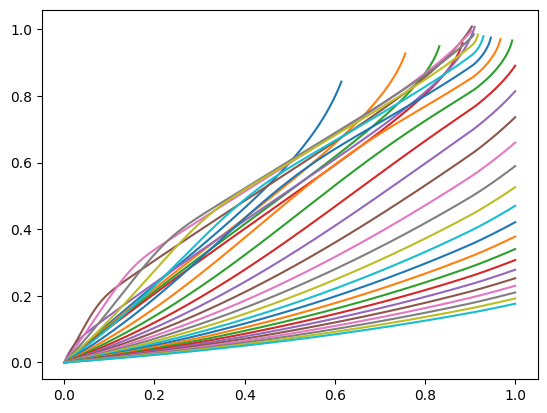

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]
total solubles = 2.9813278280712607


/tmp/ipykernel_18075/1832938454.py:115: RuntimeWarning: invalid value encountered in multiply
  gpv[i] = np.trapz(vflow*clvial_d,t_interval)*A


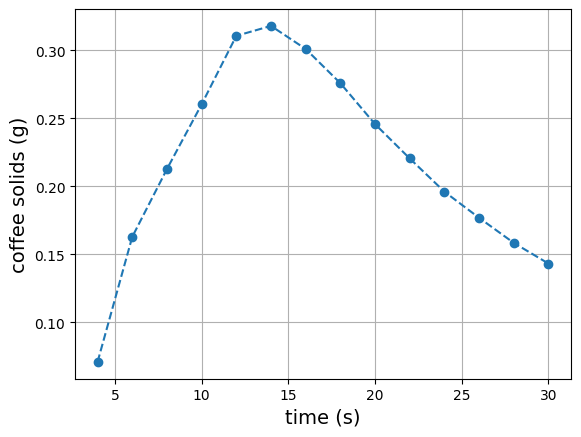

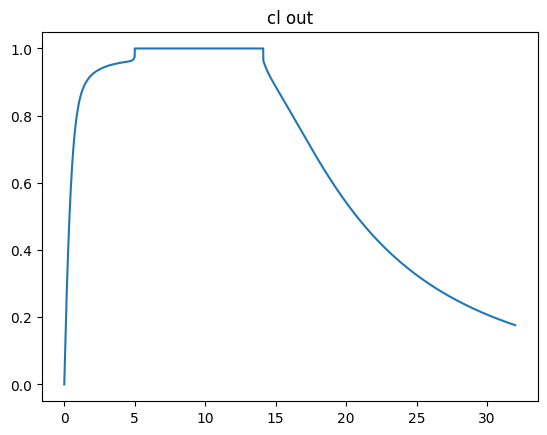

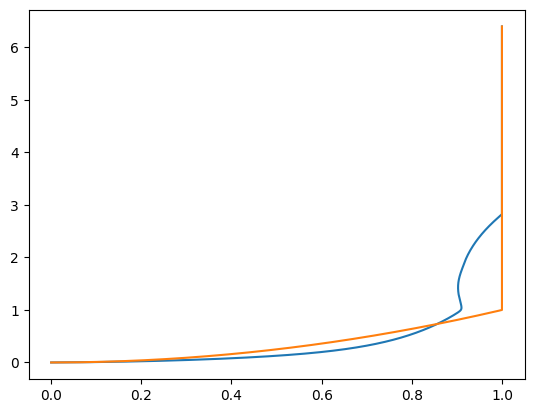

(array([0.        , 0.03845131, 0.06557269, ..., 1.        , 1.        ,
        1.        ]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.33398888e-05, 8.66797775e-05, ...,
         1.72059358e-02, 1.72492757e-02, 1.72926156e-02],
        [0.00000000e+00, 1.00516039e-04, 2.00948659e-04, ...,
         3.49656979e-02, 3.50420189e-02, 3.51182909e-02],
        ...,
        [0.00000000e+00, 2.51046760e-04, 5.02864308e-04, ...,
         1.75307665e-01, 1.76044327e-01, 1.76783103e-01],
        [0.00000000e+00, 2.50844902e-04, 5.02459960e-04, ...,
         1.75157218e-01, 1.75893217e-01, 1.76631330e-01],
        [0.00000000e+00, 2.50643470e-04, 5.02056064e-04, ...,
         1.75006934e-01, 1.75742272e-01, 1.76479721e-01]]),
 array([           nan, 4.88317566e-04, 7.08332936e-05, 1.62788826e-04,
        2.12647789e-04, 2.60232496e-04, 3.10615402e-04, 3.17908752e-04,
        3.00945172e-04, 2.

In [15]:
Dsb = 0.021 # Diffusivity in boulders
csat = 190 # saturation concentration of liquid 
cb0 = 238 # initial concentration in boulders
cb0 = cb0/csat # non-dimensionalise
cf0 = 277 # initial concentration in fines
cf0 = cf0/csat  #non-dimensionalise
make_coffee(Dsb,csat,cf0, cb0,fig=4) 